In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime
import os

In [2]:
base_dir = "sliding_years_EDA"
if not (os.path.exists(base_dir)):
              os.makedirs(base_dir)

In [3]:
def sliding_window_graph_creation(df, window_len, overlap_len):
    
    df = df[(df['start_zone_encoded'] != 264) & (df['start_zone_encoded'] != 265) & (df['end_zone_encoded'] != 264) & (df['end_zone_encoded'] != 265)]
    df['start_time'] = pd.to_datetime(df['start_time'], unit = 's')
    df['stop_time'] = pd.to_datetime(df['stop_time'], unit = 's')
    df = df.sort_values(by = 'start_time').reset_index()
    df = df[['start_zone_encoded', 'end_zone_encoded', 'user_member_encoded', 'start_time', 'stop_time', 'weight']]

    window_size = pd.DateOffset(months=window_len)
    overlap_size = pd.DateOffset(months=overlap_len)

    # Adjust start time to the beginning of the day
    start_time = df['start_time'].min().replace(day=1, hour=0, minute=0, second=0)
    # print(f'start time : {start_time}')

    # Adjust stop time to the end of the day
    stop_time = (df['stop_time'].max() + pd.DateOffset(months=1)).normalize()
    # print(f'stop time : {stop_time}')

    window_graphs_total = []
    window_graphs_customers = []
    window_graphs_subscribers = []

    days = []
    
    end_time = start_time + window_size
    # print(f'end time : {end_time}')
    # Iterate over sliding windows with overlap
    while end_time <= stop_time:
        # Filter the DataFrame for data within the current window
        window_data = df[(df['start_time'] >= start_time) & (df['stop_time'] < end_time)]

        total_df = window_data.groupby(['start_zone_encoded', 'end_zone_encoded']).agg({'weight':'sum'}).reset_index()
        customers_df = window_data.groupby(['start_zone_encoded', 'end_zone_encoded', 'user_member_encoded']).agg({'weight':'sum'}).reset_index()
        subscribers_df = window_data.groupby(['start_zone_encoded', 'end_zone_encoded', 'user_member_encoded']).agg({'weight':'sum'}).reset_index()

        customers_df = customers_df[customers_df['user_member_encoded'] == 1]
        subscribers_df = subscribers_df[subscribers_df['user_member_encoded'] == 0]

#         total_df.rename(columns = {'stop_time' : 'weight'}, inplace = True)
#         customers_df.rename(columns = {'stop_time' : 'weight'}, inplace = True)
#         subscribers_df.rename(columns = {'stop_time' : 'weight'}, inplace = True)

        G_total = nx.from_pandas_edgelist(total_df, source='start_zone_encoded', target='end_zone_encoded', edge_attr='weight', create_using=nx.DiGraph)
        G_customers = nx.from_pandas_edgelist(customers_df, source='start_zone_encoded', target='end_zone_encoded', edge_attr='weight', create_using=nx.DiGraph)
        G_subscribers = nx.from_pandas_edgelist(subscribers_df, source='start_zone_encoded', target='end_zone_encoded', edge_attr='weight', create_using=nx.DiGraph)

        G_total.remove_edges_from(nx.selfloop_edges(G_total))
        G_customers.remove_edges_from(nx.selfloop_edges(G_customers))
        G_subscribers.remove_edges_from(nx.selfloop_edges(G_subscribers))

        window_graphs_total.append(G_total)
        window_graphs_customers.append(G_customers)
        window_graphs_subscribers.append(G_subscribers)

        days.append((start_time.strftime('%b-%Y'),end_time.strftime('%b-%Y')))

        # Move to the next window with overlap
        start_time += overlap_size
        end_time += overlap_size
        
    return window_graphs_total, window_graphs_customers, window_graphs_subscribers, days

In [4]:
def graph_EDA(graphs, window, string):
    
    path = os.path.join(base_dir,string)
    
    # number of nodes and number of edges
    num_nodes = [current_graph.number_of_nodes() for current_graph in graphs]
    num_arcs = [current_graph.number_of_edges() for current_graph in graphs]

    df1 = pd.DataFrame({f'n_arcs_{string}':num_arcs}, index=window)
    df1.plot(figsize=(12, 6), style={f'n_arcs_{string}': '-'})
    plt.xlabel('window')
    plt.xticks(fontsize=7)
    plt.ylabel('count')
    title1 = ""
    if string == 'total':
        title1 = 'Evolution of no. of citibike trips'
#         plt.title('Evolution of no. of citibike trips')

    else:
        title1 = f'Evolution of no. of citibike trips by {string}s'
#         plt.title(f'Evolution of no. of citibike trips by {string}s')
    plt.title(title1)
    plt.grid()
    if string == 'total':  
        plt.legend(['Total trips'])
    else:
        plt.legend([f'Total trips by {string}s'])
    temp1 = title1+".png"
    full_path1 = os.path.join(path,temp1)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path1)
    plt.show()

    df2 = pd.DataFrame({f'n_nodes_{string}':num_nodes}, index=window)
    df2.plot(figsize=(12, 6), style={f'n_nodes_{string}': '-'})
    plt.xlabel('window')
    plt.xticks(fontsize=7)
    plt.ylabel('count')
    title2 = ""
    if string == 'total':  
        title2 = 'Evolution of no. of citibike stations used'
#         plt.title('Evolution of no. of citibike stations used')
    else:
        title2 = f'Evolution of no. of citibike stations used by {string}s'
#         plt.title(f'Evolution of no. of citibike stations used by {string}s')
    plt.title(title2)
    plt.grid()
    if string == 'total':  
        plt.legend(['No. of stations used'])
    else:
        plt.legend([f'No. of stations used by {string}s'])
    temp2 = title2+".png"
    full_path2 = os.path.join(path,temp2)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path2)
    plt.show()
    
    # Average degree
    avg_degree = [sum(dict(G.in_degree()).values()) / len(G) if len(G) > 0 else 0 for G in graphs]
    
    df3 = pd.DataFrame({f'avg_degree_{string}':avg_degree}, index=window)
    df3.plot(figsize=(12, 6), style={f'avg_degree_{string}': '-'})
    plt.xlabel('window')
    plt.xticks(fontsize=7)
    plt.ylabel('Average Degree')
    title3 = ''
    if string == 'total':  
        title3 = 'Evolution of Average Degree of citibike trips'
#         plt.title('Evolution of Average Degree of citibike trips')
    else:
        title3 = f'Evolution of Average Degree of citibike trips by {string}s'
#         plt.title(f'Evolution of Average Degree of citibike trips by {string}s')
    plt.title(title3)
    plt.grid()
    plt.legend(['Average degree'])
    temp3 = title3+".png"
    full_path3 = os.path.join(path,temp3)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path3)
    plt.show()
    
    # Clustering Coefficient
    clustering_coeff = [nx.average_clustering(G) if len(G) > 0 else 0 for G in graphs]

    df4 = pd.DataFrame({f'clustering_coeff_{string}':clustering_coeff}, index=window)
    df4.plot(figsize=(12, 6), style={f'clustering_coeff_{string}': '-'})
    plt.xlabel('window')
    plt.xticks(fontsize=7)
    plt.ylabel('Clustering Coefficient')
    title4 = ''
    if string == 'total':
        title4 = 'Evolution of clustering coefficient of citibike trips'
#         plt.title('Evolution of clustering coefficient of citibike trips')
    else:
        title4 = f'Evolution of clustering coefficient of citibike trips of {string}s'
#         plt.title(f'Evolution of clustering coefficient of citibike trips of {string}s')
    plt.title(title4)
    plt.grid()
    plt.legend(['Average Clustering Coefficient'])
    temp4 = title4+".png"
    full_path4 = os.path.join(path,temp4)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path4)
    plt.show()
    
    # Community detection and its similarity
    
    temp_module = nx.algorithms.community.louvain
    list_of_partition_labels = [[0]*264 for _ in range(len(graphs))]

    count = 0
    for G in graphs:

        if len(G) > 0:
            partitions = temp_module.louvain_communities(G, weight = 'weight')
        else:
            count+=1
            continue

        for i in range(len(partitions)):
            for item in partitions[i]:
                list_of_partition_labels[count][item] = i+1

        count+=1
    
    from sklearn.metrics import adjusted_mutual_info_score as AMI, normalized_mutual_info_score as NMI

    sequential_ami_scores = []
    first_ami_scores = []
    sequential_nmi_scores = []
    first_nmi_scores = []

    for i in range(len(list_of_partition_labels)):

        if i == 0:
            ami_score = AMI(list_of_partition_labels[i], list_of_partition_labels[i])
            sequential_ami_scores.append(ami_score)
            first_ami_scores.append(ami_score)

            nmi_score = NMI(list_of_partition_labels[i], list_of_partition_labels[i])
            sequential_nmi_scores.append(nmi_score)
            first_nmi_scores.append(nmi_score)
            continue

        non_zero_values_list1 = [x for x, y in zip(list_of_partition_labels[i], list_of_partition_labels[i-1]) if x != 0 and y != 0]
        non_zero_values_list2 = [y for x, y in zip(list_of_partition_labels[i], list_of_partition_labels[i-1]) if x != 0 and y != 0]

        ami_score_sequential = AMI(non_zero_values_list1, non_zero_values_list2)
        sequential_ami_scores.append(ami_score_sequential)

        nmi_score_sequential = NMI(non_zero_values_list1, non_zero_values_list2)
        sequential_nmi_scores.append(nmi_score_sequential)

        non_zero_values_list3 = [x for x, y in zip(list_of_partition_labels[i], list_of_partition_labels[0]) if x != 0 and y != 0]
        non_zero_values_list4 = [y for x, y in zip(list_of_partition_labels[i], list_of_partition_labels[0]) if x != 0 and y != 0]

        first_ami_score = AMI(non_zero_values_list3, non_zero_values_list4)
        first_ami_scores.append(first_ami_score)

        first_nmi_score = NMI(non_zero_values_list3, non_zero_values_list4)
        first_nmi_scores.append(first_nmi_score)

    df5 = pd.DataFrame({f'sequential_ami_scores_{string}':sequential_ami_scores, f'sequential_nmi_scores_{string}':sequential_nmi_scores, f'first_ami_scores_{string}':first_ami_scores, f'first_nmi_scores_{string}':first_nmi_scores}, index=window)
    df5.plot(figsize=(12, 6), style={f'sequential_ami_scores_{string}': '-', f'sequential_nmi_scores_{string}': '--', f'first_ami_scores_{string}': ':', f'first_nmi_scores_{string}': '-.'})
    plt.xlabel('window')
    plt.xticks(fontsize=7)
    plt.ylabel('Similarity value')
    title5 = ''
    if string == 'total':
        title5 = 'Similarity index of communities of citibike trips'
#         plt.title('Similarity index of communities of citibike trips')
    else:
        title5 = f'Similarity index of communities of citibike trips made by {string}s'
#         plt.title(f'Similarity index of communities of citibike trips made by {string}s')
    plt.title(title5)
    plt.grid()
    plt.legend(['Sequential AMI score', 'Sequential NMI score', 'Partial AMI score', 'Partial NMI score'])
    temp5 = title5+".png"
    full_path5 = os.path.join(path,temp5)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path5)
    plt.show()
    
    # Degree Sequence
    
    high_in_degree_percent = []
    high_out_degree_percent = []
    low_in_degree_percent = []
    low_out_degree_percent = []

    for G in graphs:

        in_degree_sequence = sorted([d for n, d in G.in_degree()])

        high_in_nums = [d for d in in_degree_sequence if d >= 0.6*(G.number_of_nodes())]
        low_in_nums = [d for d in in_degree_sequence if d <= 0.1*(G.number_of_nodes())]

        out_degree_sequence = sorted([d for n, d in G.out_degree()])

        high_out_nums = [d for d in out_degree_sequence if d >= 0.6*(G.number_of_nodes())]
        low_out_nums = [d for d in out_degree_sequence if d <= 0.1*(G.number_of_nodes())]

        high_in_degree_percent.append(len(high_in_nums)*100/(G.number_of_nodes()) if len(G)>0 else 0)
        high_out_degree_percent.append(len(high_out_nums)*100/(G.number_of_nodes()) if len(G)>0 else 0)
        low_in_degree_percent.append(len(low_in_nums)*100/(G.number_of_nodes()) if len(G)>0 else 0)
        low_out_degree_percent.append(len(low_out_nums)*100/(G.number_of_nodes()) if len(G)>0 else 0)

    df6 = pd.DataFrame({f'high_in_degree_percent_{string}':high_in_degree_percent, f'high_out_degree_percent_{string}':high_out_degree_percent, f'low_in_degree_percent_{string}':low_in_degree_percent, f'low_out_degree_percent_{string}':low_out_degree_percent}, index=window)
    df6.plot(figsize=(12, 6), style={f'high_in_degree_percent_{string}': '-', f'high_out_degree_percent_{string}': '--', f'low_in_degree_percent_{string}': ':', f'low_out_degree_percent_{string}': '-.'})
    plt.xlabel('window')
    plt.xticks(fontsize=7)
    plt.ylabel('Percentage(%)')
    title6 = ''
    if string == 'total':
        title6 = 'Number of highly busy and least busy citibike stations'
#         plt.title('Number of highly busy and least busy citibike stations')
    else:
        title6 = f'Number of highly busy and least busy citibike stations used by {string}s'
#         plt.title(f'Number of highly busy and least busy citibike stations used by {string}s')
    plt.title(title6)
    plt.grid()
    plt.legend(['High incoming traffic(>= 60% of nodes)', 'High outgoing traffic(>= 60% of nodes)', 'Low incoming traffic(<= 10% of nodes)', 'Low outgoing traffic(<= 10% of nodes)'])
    temp6 = title6+".png"
    full_path6 = os.path.join(path,temp6)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path6)
    plt.show()
    
    # Centrality measures
    
    in_degree_centrality = [0]*263
    out_degree_centrality = [0]*263
    betweenness_centrality = [0]*263 #without weights
    eigenvector_centrality = [0]*263 #with weights

    for G in graphs:
        
        if len(G) == 0: continue

        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        betweenness = nx.betweenness_centrality(G)
        eigenvector = nx.eigenvector_centrality(G, max_iter=500, tol=1e-4, weight='weight')

        max_in = max(in_degrees.values())
        max_out = max(out_degrees.values())
        max_betweenness = max(betweenness.values())
        max_eigenvector = max(eigenvector.values())

        max_ins = [key for key, value in in_degrees.items() if value == max_in]
        max_outs = [key for key, value in out_degrees.items() if value == max_out]
        max_betweenness_s = [key for key, value in betweenness.items() if value == max_betweenness]
        max_eigenvectors = [key for key, value in eigenvector.items() if value == max_eigenvector]

        in_degree_centrality = [val+1 if idx in max_ins else val for idx, val in enumerate(in_degree_centrality)]
        out_degree_centrality = [val+1 if idx in max_outs else val for idx, val in enumerate(out_degree_centrality)]
        betweenness_centrality = [val+1 if idx in max_betweenness_s else val for idx, val in enumerate(betweenness_centrality)]
        eigenvector_centrality = [val+1 if idx in max_eigenvectors else val for idx, val in enumerate(eigenvector_centrality)]

    in_degree_centrality = {index: value for index, value in enumerate(in_degree_centrality)}
    out_degree_centrality = {index: value for index, value in enumerate(out_degree_centrality)}
    betweenness_centrality = {index: value for index, value in enumerate(betweenness_centrality)}
    eigenvector_centrality = {index: value for index, value in enumerate(eigenvector_centrality)}

    sorted_in_degree_centrality = dict(sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True))
    sorted_out_degree_centrality = dict(sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True))
    sorted_betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
    sorted_eigenvector_centrality = dict(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))

    top_10_in_degree = dict(list(sorted_in_degree_centrality.items())[:10])
    top_10_out_degree = dict(list(sorted_out_degree_centrality.items())[:10])
    top_10_betweenness = dict(list(sorted_betweenness_centrality.items())[:10])
    top_10_eigenvector = dict(list(sorted_eigenvector_centrality.items())[:10])
    
    zones = pd.read_csv('taxi_zones.csv')
    zones = zones.drop(['Borough', 'service_zone'], axis=1)
    
    # in degree centrality
    top_non_zero_in_degree = {k: v for k, v in top_10_in_degree.items() if v != 0}
    nodes_strings_in_degree = [zones.loc[zones['LocationID'] == node+1, 'Zone'].iloc[0] for node in top_non_zero_in_degree.keys()]
    frequencies_in_degree = list(top_non_zero_in_degree.values())

    plt.figure(figsize=(10, 6))
    plt.barh(nodes_strings_in_degree, frequencies_in_degree)  # Flip x and y axis
    plt.ylabel('Zone')  # Set y-axis label
    plt.xlabel('Frequency')  # Set x-axis label
    title7 = ''
    if string == 'total':  
        title7 = 'Most central zones based on in degree centrality'
#         plt.title('Most central zones based on in degree centrality')
    else:
        title7 = f'Most central zones used by {string}s based on in degree centrality'
#         plt.title(f'Most central zones used by {string}s based on in degree centrality')
    plt.title(title7)
    temp7 = title7+".png"
    full_path7 = os.path.join(path,temp7)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path7)
    plt.show()
    
    # out degree centrality
    top_non_zero_out_degree = {k: v for k, v in top_10_out_degree.items() if v != 0}
    nodes_strings_out_degree = [zones.loc[zones['LocationID'] == node+1, 'Zone'].iloc[0] for node in top_non_zero_out_degree.keys()]
    frequencies_out_degree = list(top_non_zero_out_degree.values())

    plt.figure(figsize=(10, 6))
    plt.barh(nodes_strings_out_degree, frequencies_out_degree)  # Flip x and y axis
    plt.ylabel('Zone')  # Set y-axis label
    plt.xlabel('Frequency')  # Set x-axis label
    title8 = ''
    if string == 'total':
        title8 = 'Most central zones based on out degree centrality'
#         plt.title('Most central zones based on out degree centrality')
    else:
        title8 = f'Most central zones used by {string}s based on out degree centrality'
#         plt.title(f'Most central zones used by {string}s based on out degree centrality')
    plt.title(title8)
    temp8 = title8+".png"
    full_path8 = os.path.join(path,temp8)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path8)
    plt.show()
    
    # betweenness centrality
    top_non_zero_betweenness = {k: v for k, v in top_10_betweenness.items() if v != 0}
    nodes_strings_betweenness = [zones.loc[zones['LocationID'] == node+1, 'Zone'].iloc[0] for node in top_non_zero_betweenness.keys()]
    frequencies_betweenness = list(top_non_zero_betweenness.values())

    plt.figure(figsize=(10, 6))
    plt.barh(nodes_strings_betweenness, frequencies_betweenness)  # Flip x and y axis
    plt.ylabel('Zone')  # Set y-axis label
    plt.xlabel('Frequency')  # Set x-axis label
    title9 = ''
    if string == 'total':
        title9 = 'Most central zones based on betweenness centrality'
#         plt.title('Most central zones based on betweenness centrality')
    else:
        title9 = f'Most central zones used by {string}s based on betweenness centrality'
#         plt.title(f'Most central zones used by {string}s based on betweenness centrality')
    plt.title(title9)
    temp9 = title9+".png"
    full_path9 = os.path.join(path,temp9)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path9)
    plt.show()
    
    # eigenvector centrality
    top_non_zero_eigenvector = {k: v for k, v in top_10_eigenvector.items() if v != 0}
    nodes_strings_eigenvector = [zones.loc[zones['LocationID'] == node+1, 'Zone'].iloc[0] for node in top_non_zero_eigenvector.keys()]
    frequencies_eigenvector = list(top_non_zero_eigenvector.values())

    plt.figure(figsize=(10, 6))
    plt.barh(nodes_strings_eigenvector, frequencies_eigenvector)  # Flip x and y axis
    plt.ylabel('Zone')  # Set y-axis label
    plt.xlabel('Frequency')  # Set x-axis label
    title10 = ''
    if string == 'total':
        title10 = 'Most central zones based on eigenvector centrality'
#         plt.title('Most central zones based on eigenvector centrality')
    else:
        title10 = f'Most central zones used by {string}s based on eigenvector centrality'
#         plt.title(f'Most central zones used by {string}s based on eigenvector centrality')
    plt.title(title10)
    temp10 = title10+".png"
    full_path10 = os.path.join(path,temp10)
    if not(os.path.exists(path)):
        os.makedirs(path)
    plt.savefig(full_path10)
    plt.show()

In [5]:
df = pd.read_csv('monthlyAggregatedCitibike.csv')

In [6]:
yearly_graphs_total, yearly_graphs_customers, yearly_graphs_subscribers, years = sliding_window_graph_creation(df, 12, 1)

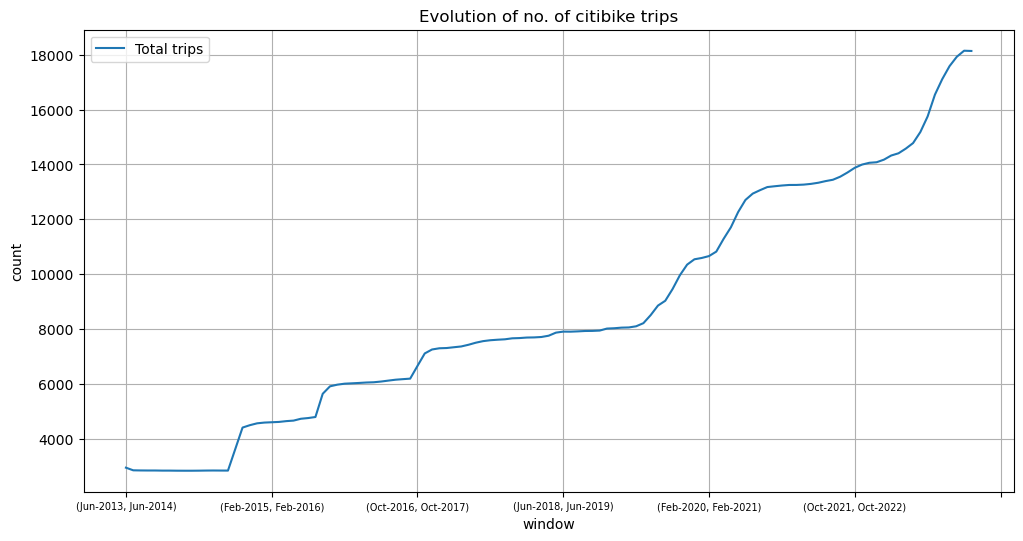

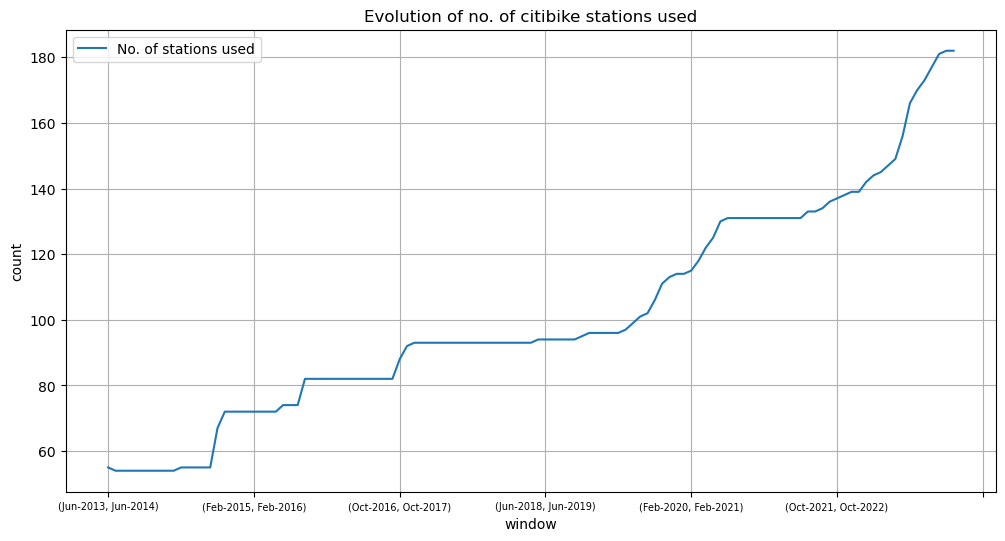

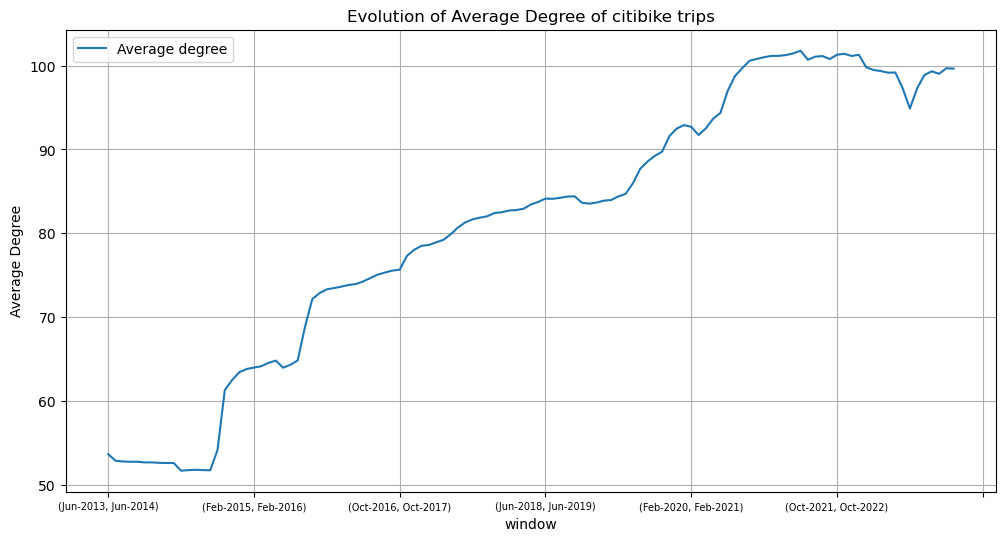

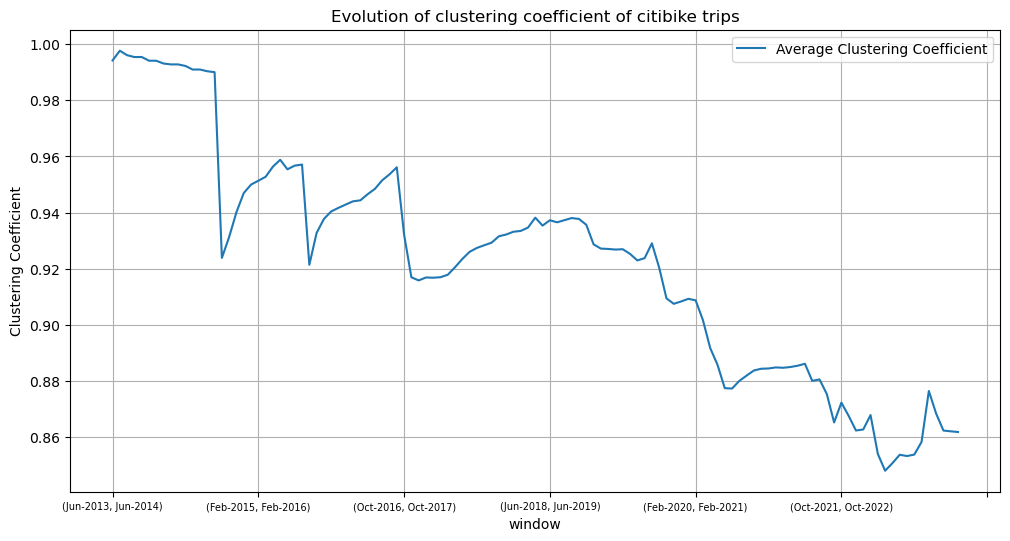

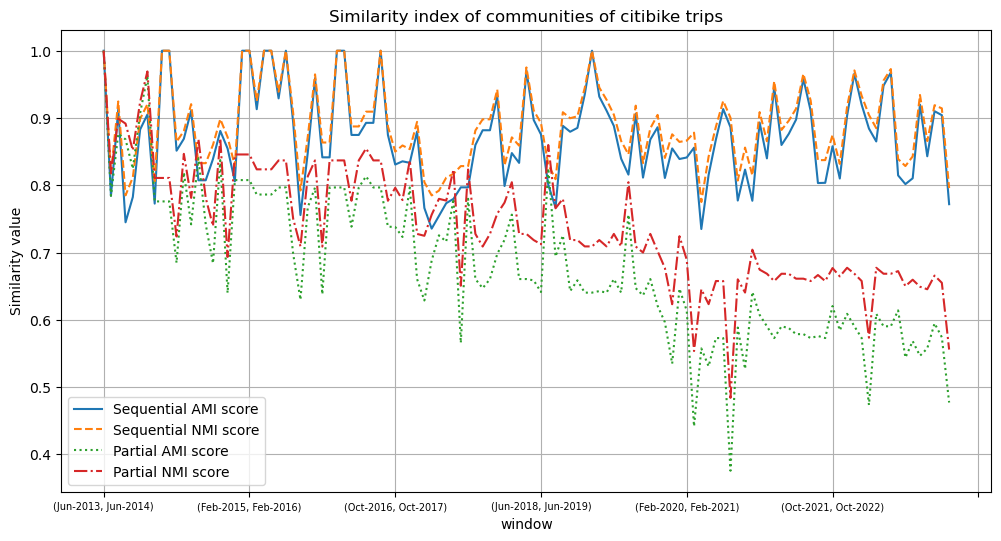

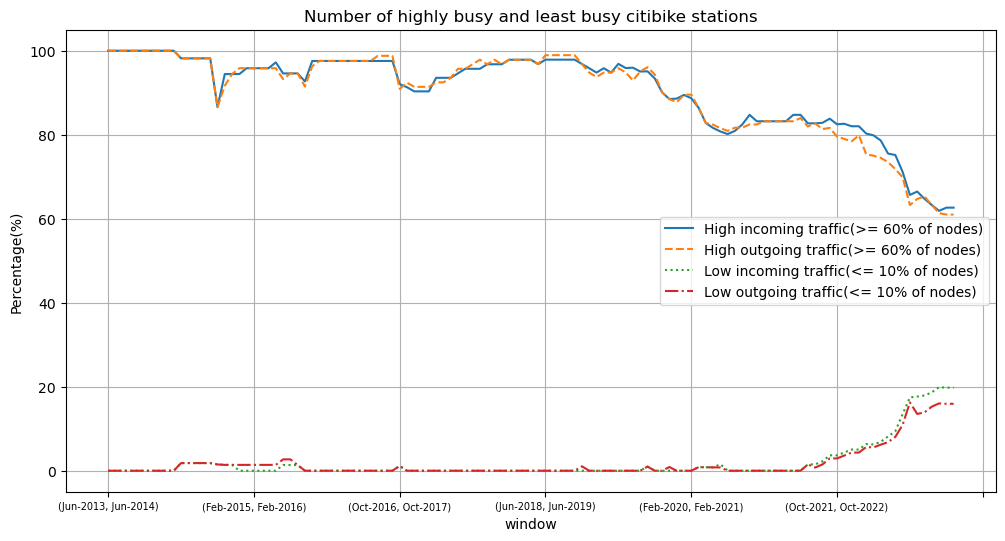

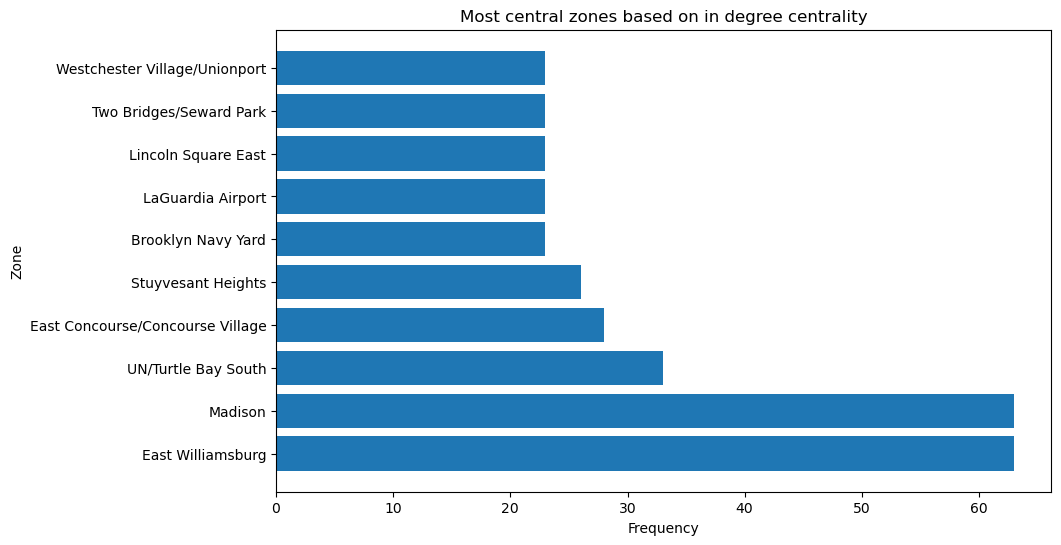

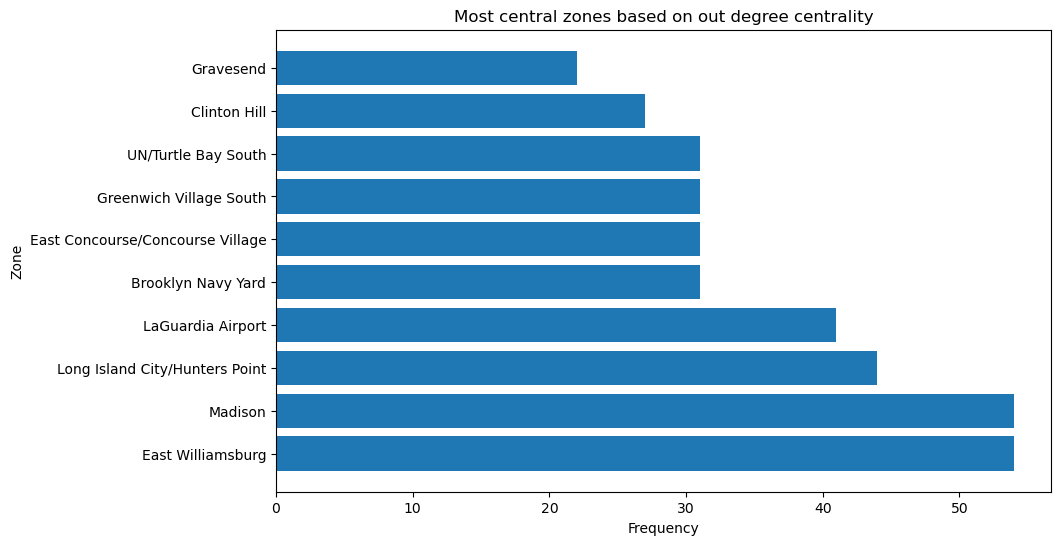

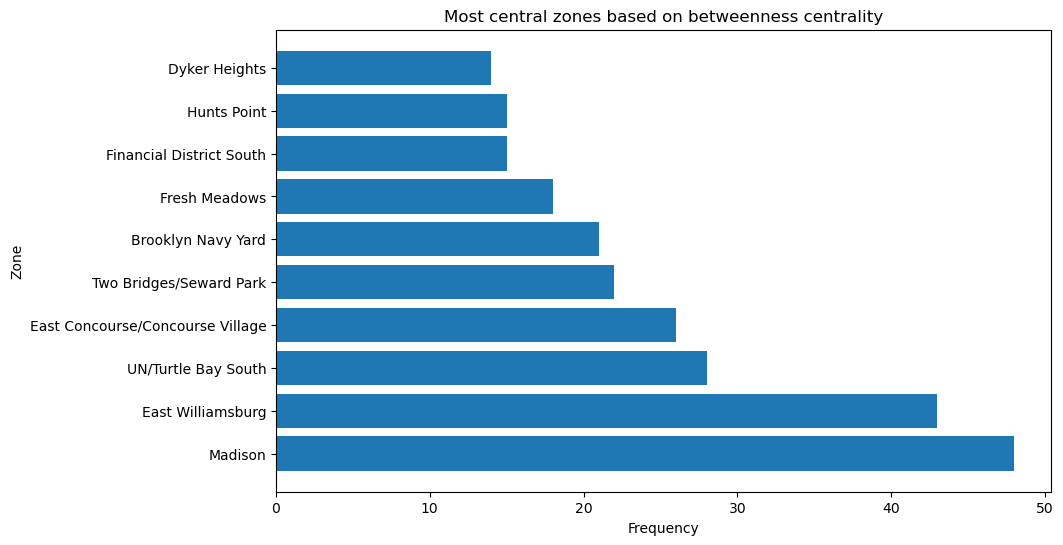

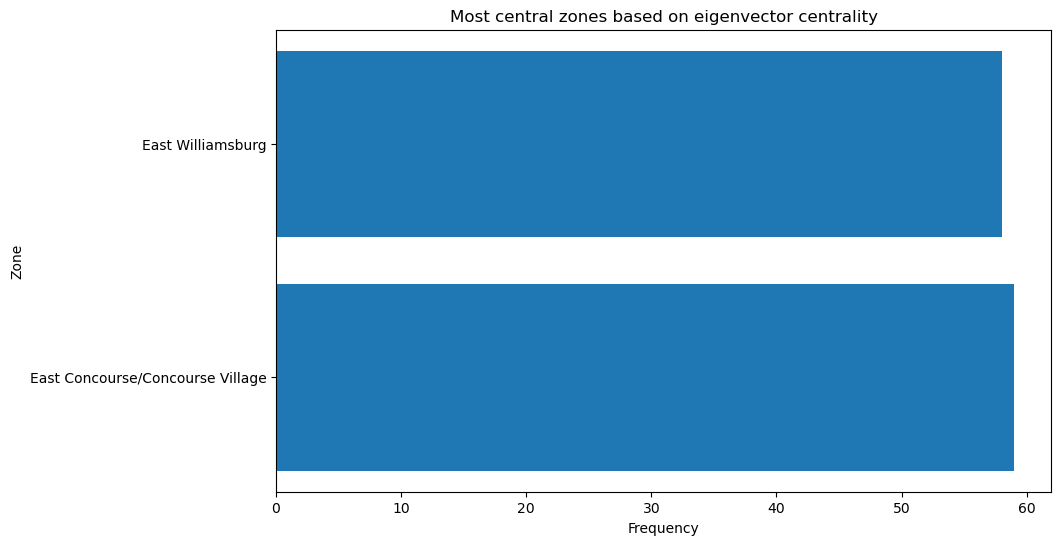

In [7]:
graph_EDA(yearly_graphs_total, years, 'total')

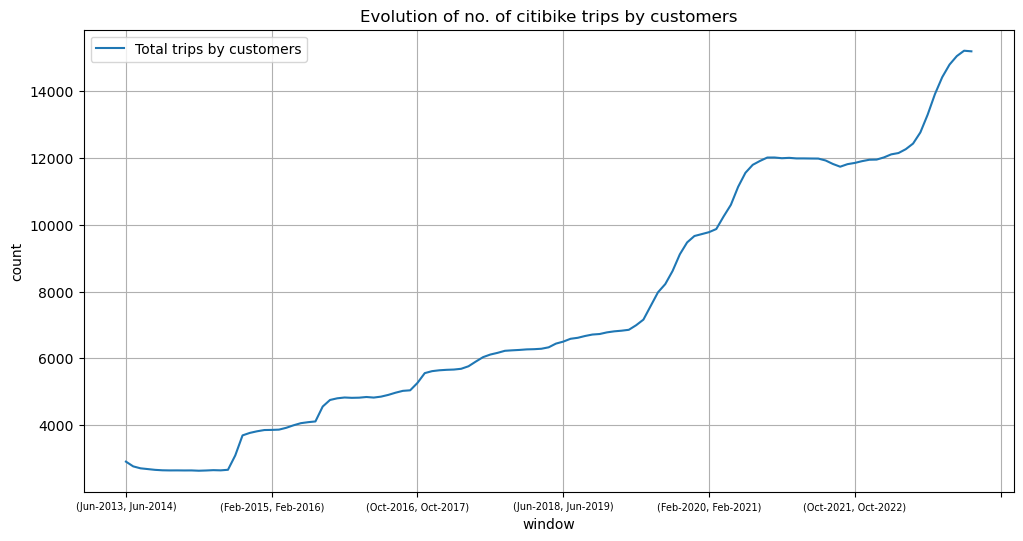

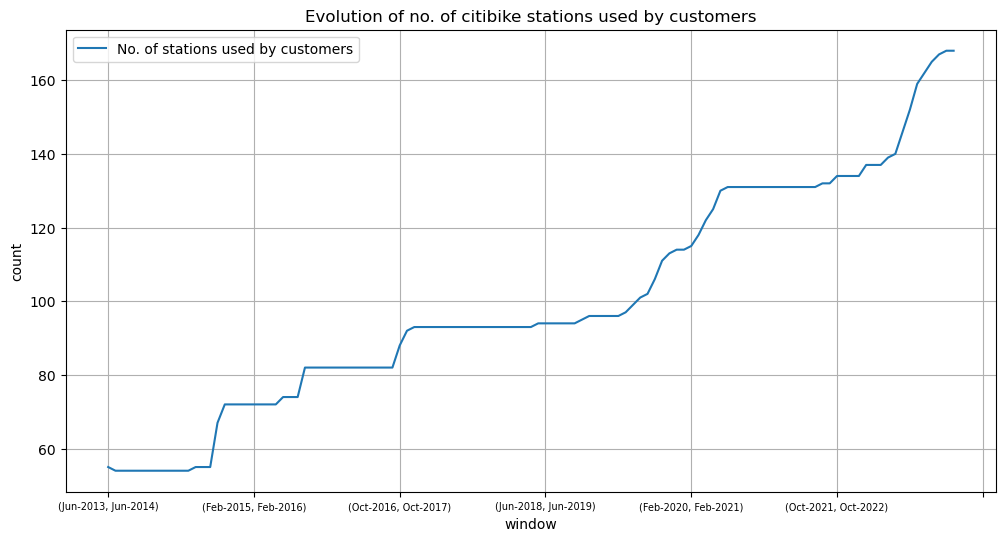

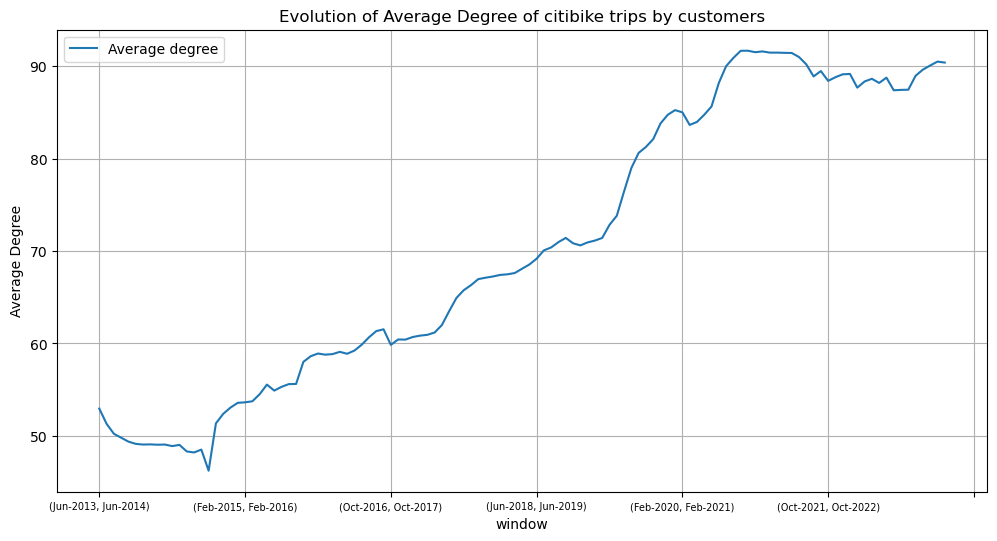

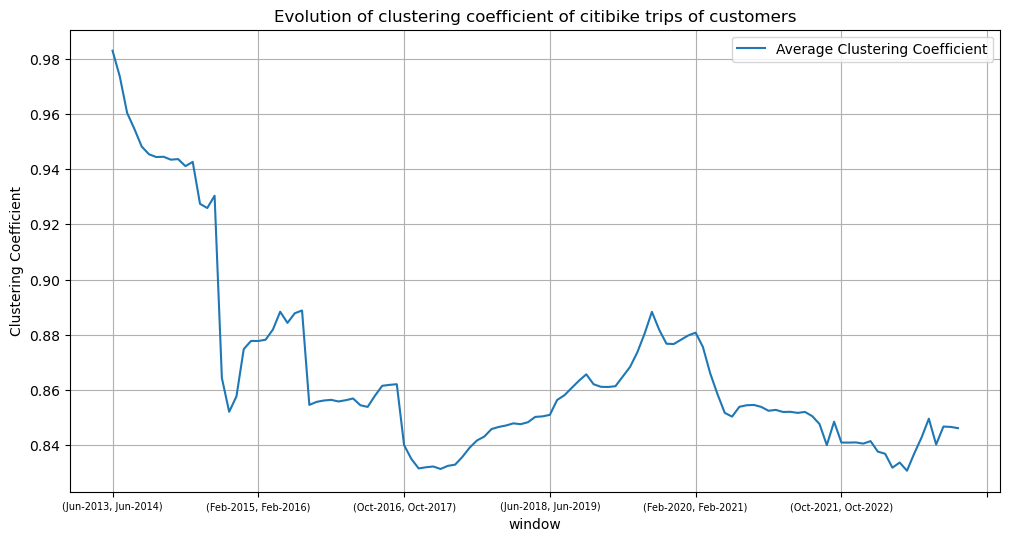

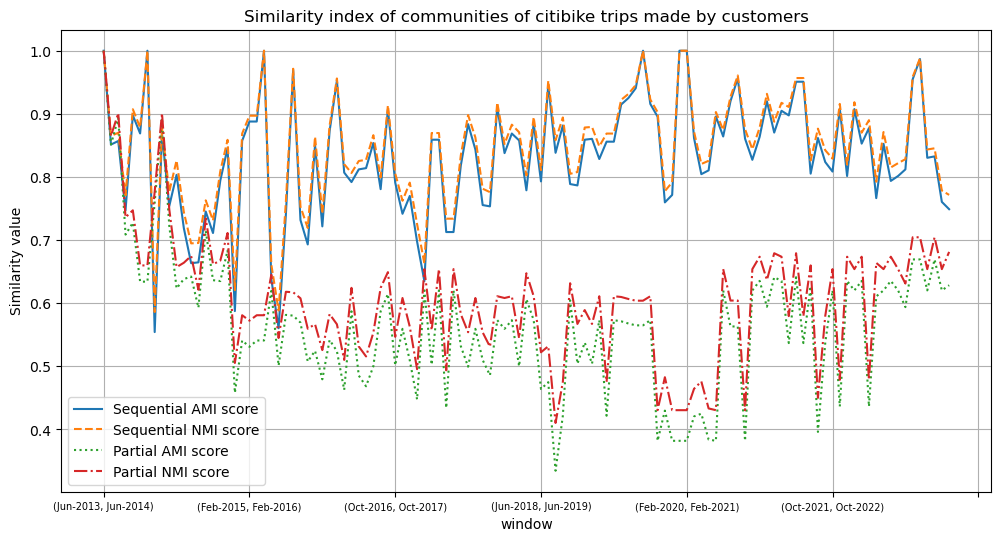

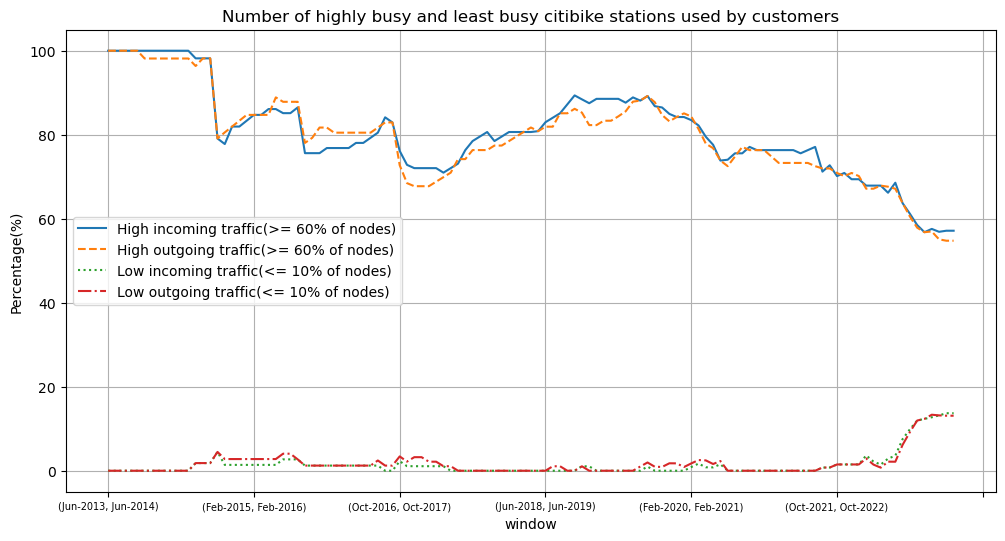

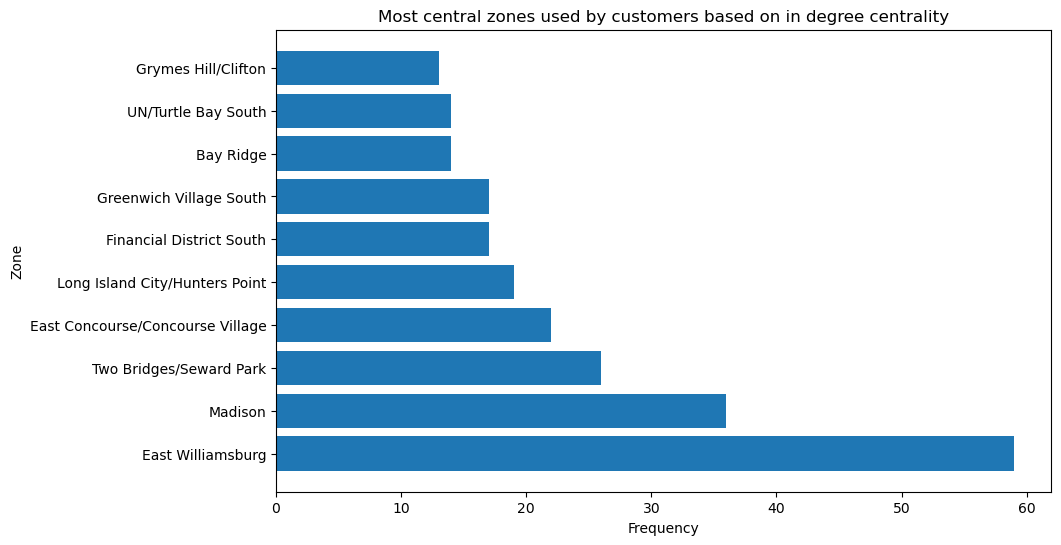

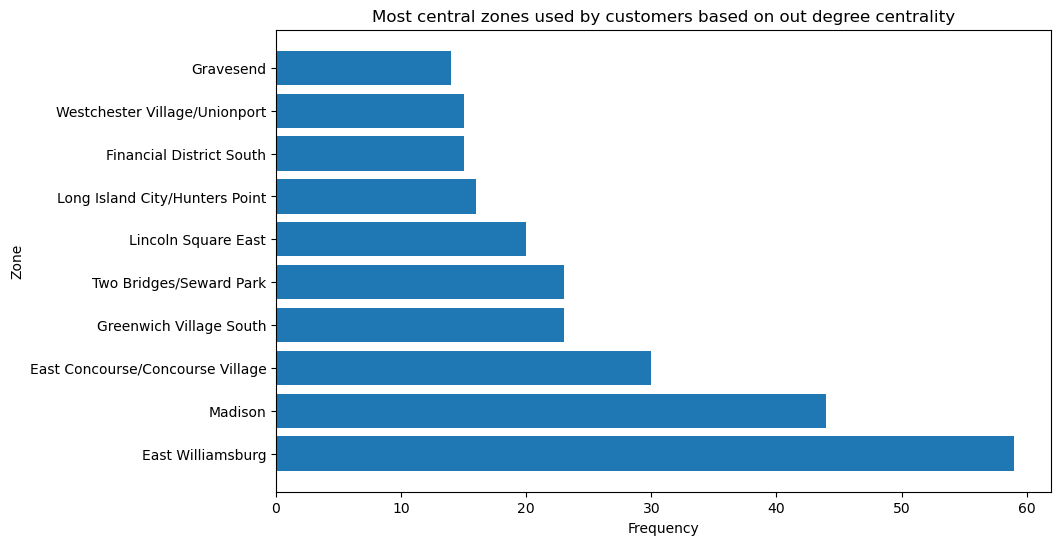

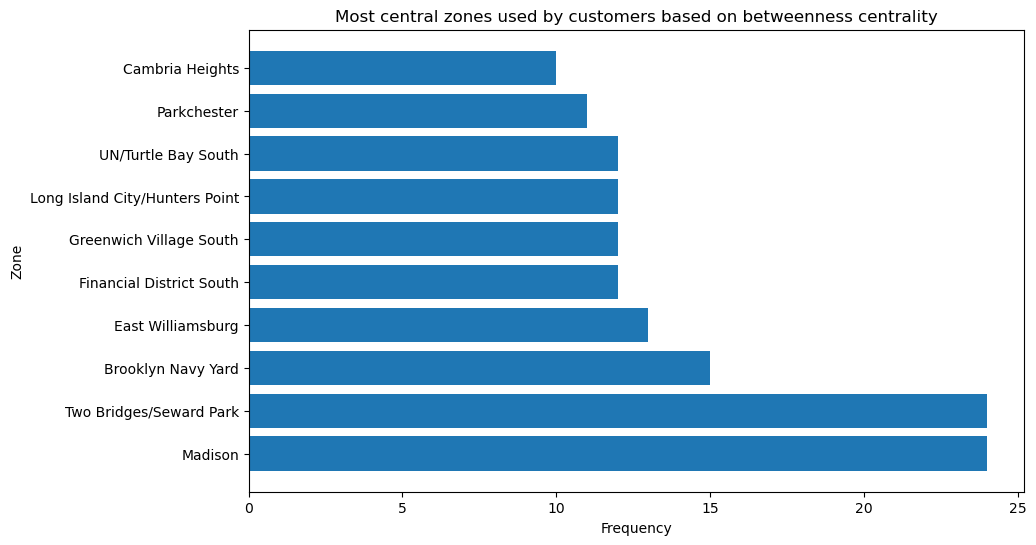

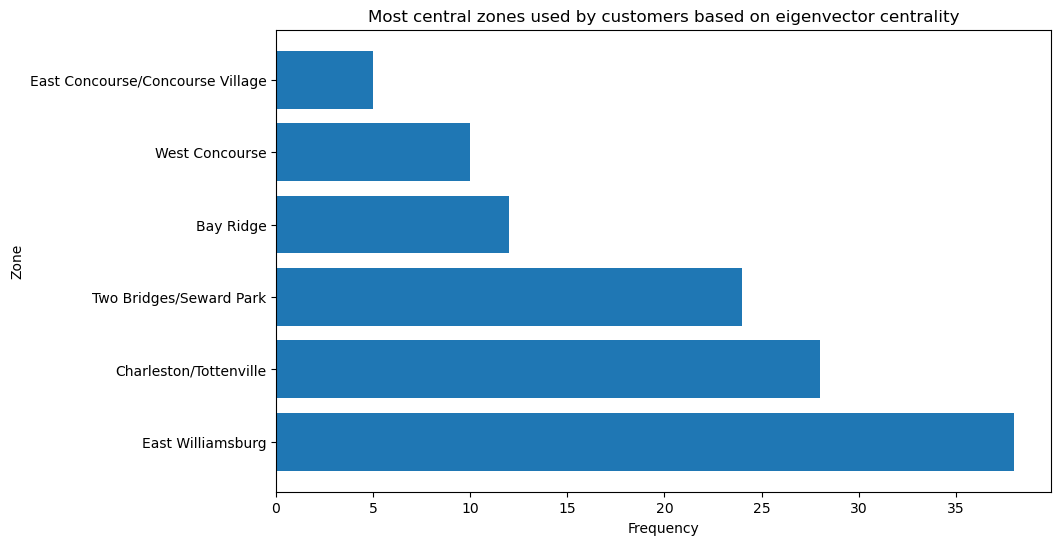

In [8]:
graph_EDA(yearly_graphs_customers, years, 'customer')

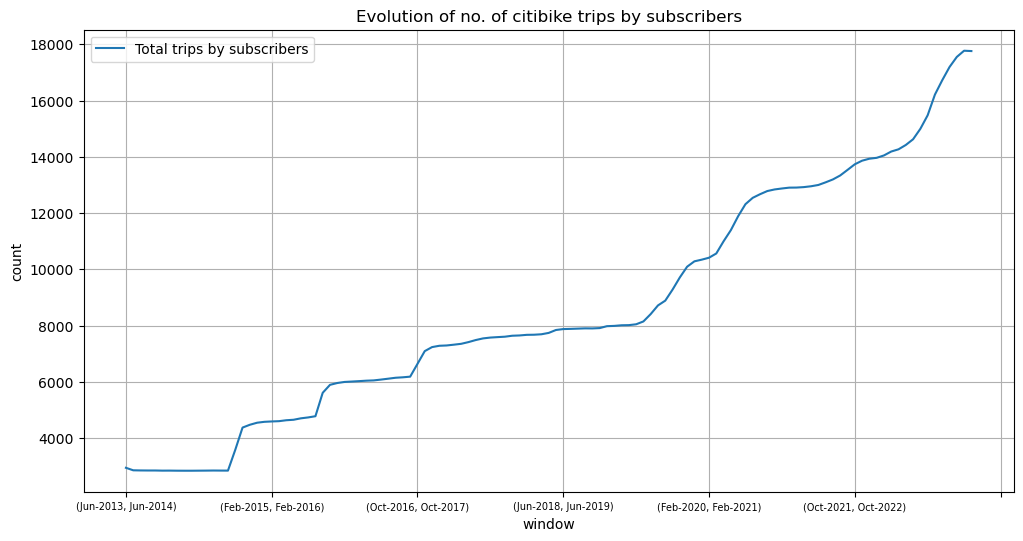

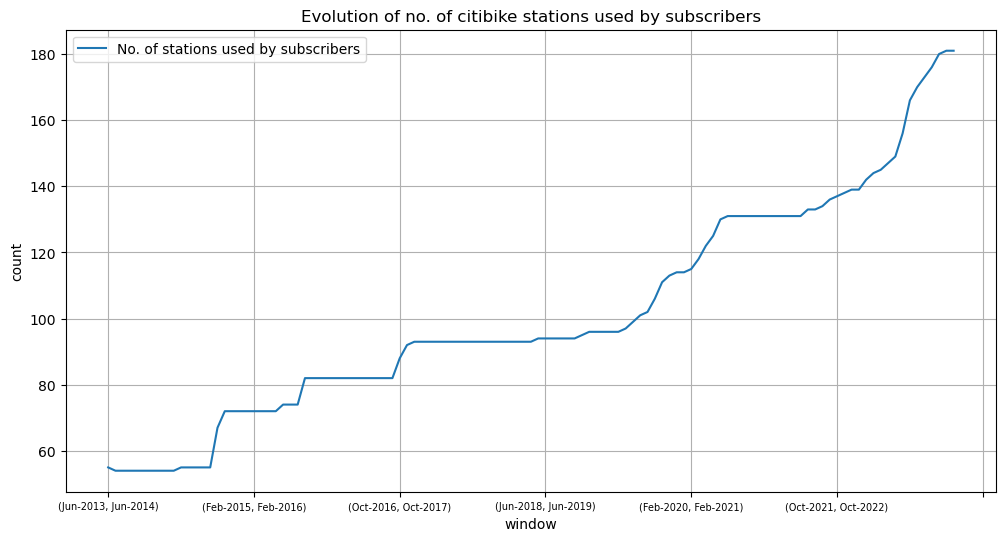

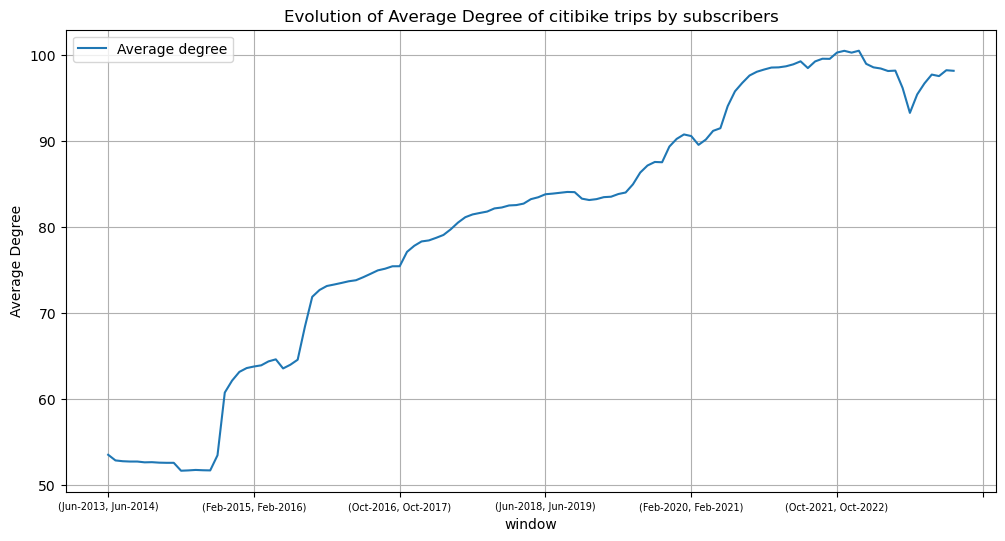

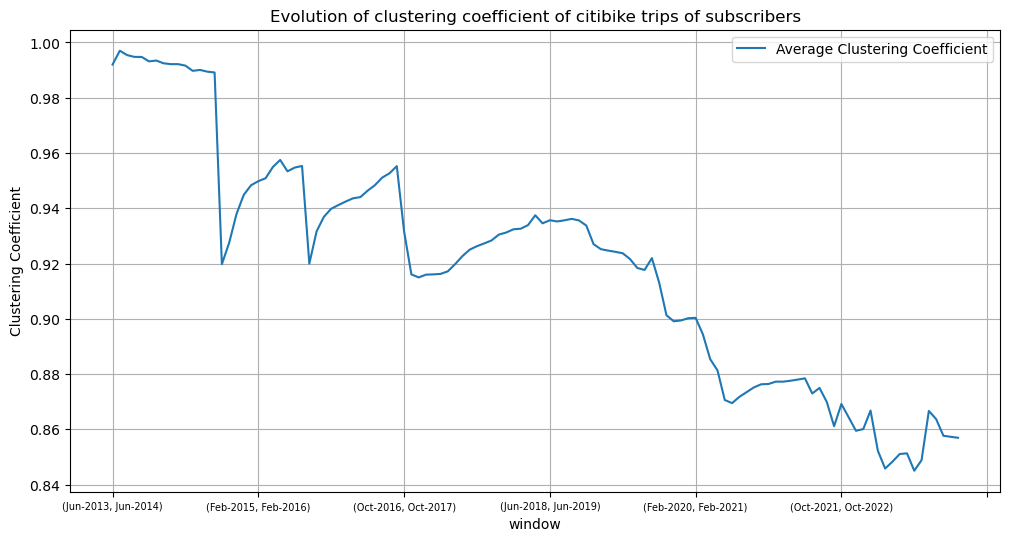

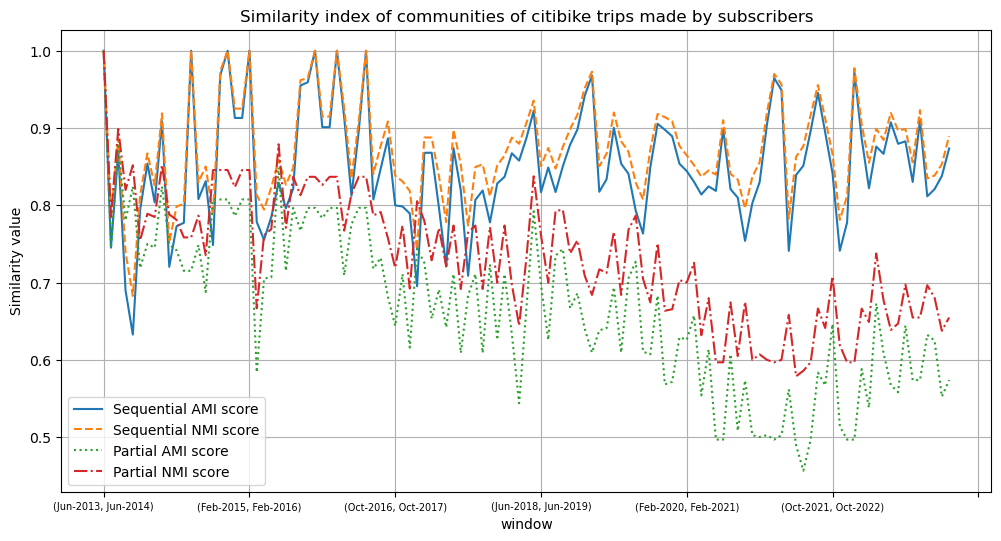

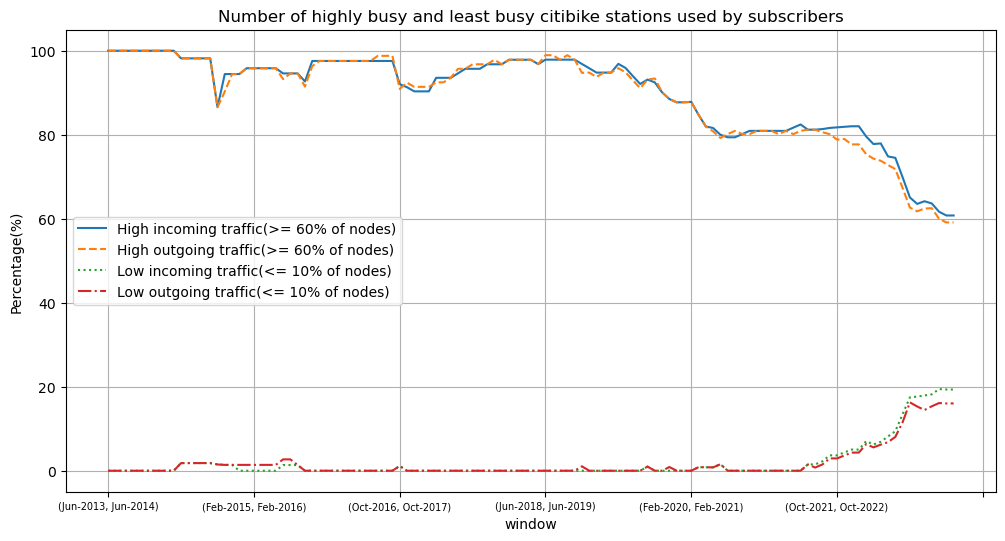

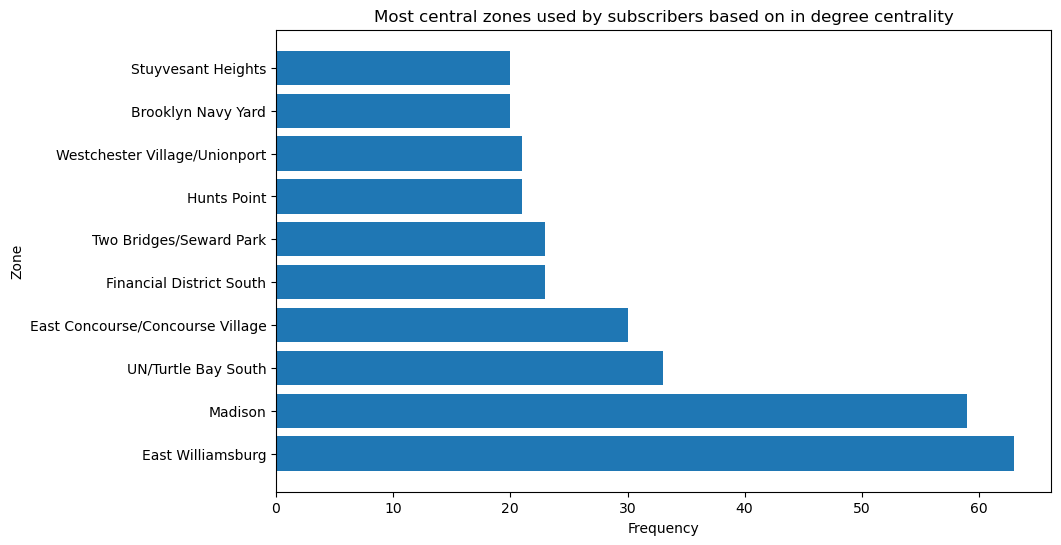

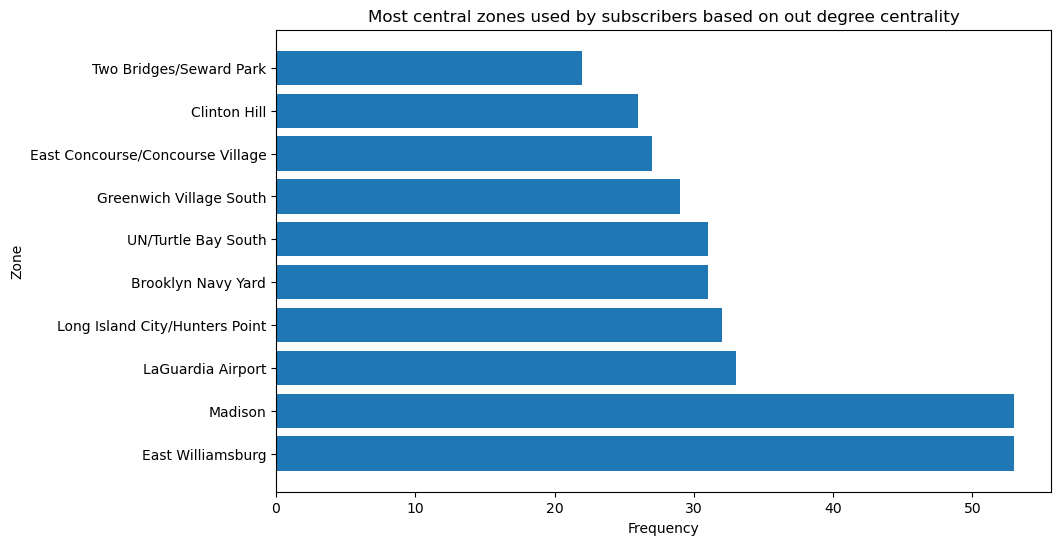

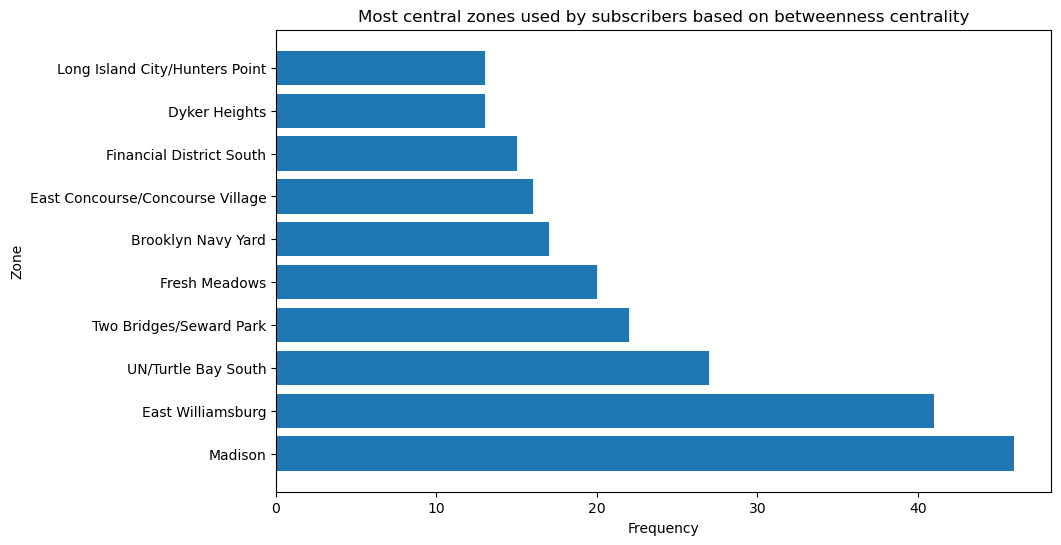

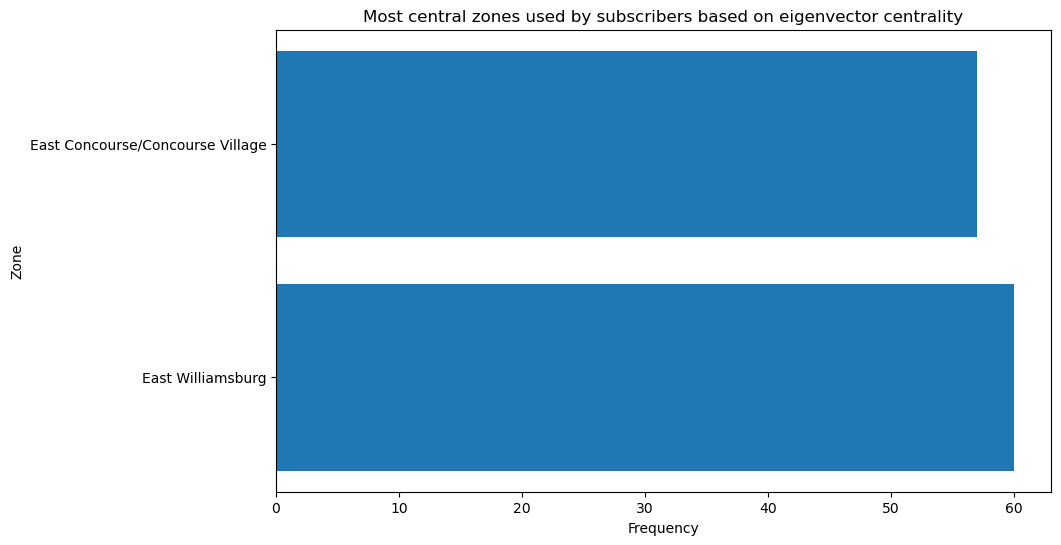

In [9]:
graph_EDA(yearly_graphs_subscribers, years, 'subscriber')